# Code for the empirical analysis in the paper 'Growth and fund structures'
### Constantinos Kardaras; Hyeng Keun Koo; Johannes Ruf
### July 2025

To run this code, the user must have access to WRDS, along with the Python package `wrds`.  For more details on WRDS and how to interact with WRDS, see the course notes on https://github.com/johruf/CRSP_on_WRDS_introduction.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import wrds   # needs to be installed, e.g. via pip

In [2]:
WRDS_LOGIN = 'XXX'    # update to your login info on WRDS

## Getting data

In [3]:
def load_data():
    """Load data from WRDS"""
    try:
        with wrds.Connection(wrds_username=WRDS_LOGIN) as db:
            df_idx = db.raw_sql("SELECT caldt AS date, vwretd, totcnt FROM crsp.dsp500_v2", 
                               date_cols='date').set_index('date')
            df_rf = db.raw_sql("SELECT date, rf FROM ff.factors_daily", 
                              date_cols='date').set_index('date')
        return df_idx, df_rf
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

df_idx, df_rf = load_data()

Loading library list...
Done


`vwretd` corresponds to CRSP's Value-Weighted Return Index (which reinvests dividends).

`rf` is from the Fama-French data, and uses 1M treasury rates. Data are only available beginning July 1st, 1926.

In [4]:
df_idx.head()

,vwretd,totcnt
date,,
1925-12-31,NaN,89
1926-01-02,0.004297,89
1926-01-04,-0.001357,89
1926-01-05,-0.004603,89
1926-01-06,0.000537,89


In [5]:
df_rf.head()

,rf
date,
1926-07-01,0.00009
1926-07-02,0.00009
1926-07-06,0.00009
1926-07-07,0.00009
1926-07-08,0.00009


In [6]:
# Getting rid of data that were not available at the time when the paper was written
CUTOFF_DATE = '2024-12-31'

In [7]:
df = df_idx.merge(df_rf, how='left', left_index=True, right_index=True)['1926-06-30':CUTOFF_DATE]

In [8]:
df.head(3)

,vwretd,totcnt,rf
date,,,
1926-06-30,0.002463,89,NaN
1926-07-01,0.002716,89,0.00009
1926-07-02,0.004275,89,0.00009


In [9]:
df.tail(3)

,vwretd,totcnt,rf
date,,,
2024-12-27,-0.011109,503,0.00017
2024-12-30,-0.010782,503,0.00017
2024-12-31,-0.004225,503,0.00017


In [10]:
# Calculate wealth processes
df['W_risky'] = (1 + df['vwretd']).cumprod()
df['W_risky'] /= df['W_risky'].iloc[0]

df['W_rf'] = (1 + df['rf']).cumprod()
df.at[df.index[0], 'W_rf'] = 1.0

df['W_disc'] = df['W_risky'] / df['W_rf']
df['disc_ret'] = df['W_disc'] / df['W_disc'].shift(1) - 1

df['C'] = (df['disc_ret']**2).cumsum()
df['R'] = df['disc_ret'].cumsum()

# Remove first day (no return data)
df = df['1926-07-01':]

In [11]:
df.head(3)

,vwretd,totcnt,rf,W_risky,W_rf,W_disc,disc_ret,C,R
date,,,,,,,,,
1926-07-01,0.002716,89,0.00009,1.002716,1.00009,1.002626,0.002626,0.000007,0.002626
1926-07-02,0.004275,89,0.00009,1.007003,1.00018,1.006821,0.004185,0.000024,0.006810
1926-07-06,0.000781,89,0.00009,1.007789,1.00027,1.007517,0.000691,0.000025,0.007501


In [12]:
df.tail(3)

,vwretd,totcnt,rf,W_risky,W_rf,W_disc,disc_ret,C,R
date,,,,,,,,,
2024-12-27,-0.011109,503,0.00017,15625.438241,23.746497,658.010235,-0.011277,3.388842,8.185651
2024-12-30,-0.010782,503,0.00017,15456.964766,23.750534,650.804931,-0.010950,3.388962,8.174700
2024-12-31,-0.004225,503,0.00017,15391.659089,23.754572,647.945130,-0.004394,3.388981,8.170306


## Auxiliary functions

In [13]:
def shrinkage_factor(nuhat, df, start_of_data=-1, start_of_plot=0, α=[], β=[]):    
    """
    Calculate shrinkage factor for one-fund model 
    alpha and beta parameters in case of restricted Gaussian prior 

    Based on: shrink(x) = 1 - 3 / (1 + tmp^(2/3) + tmp^(-2/3))
    where tmp = sqrt(1+x) + sqrt(x)
    """
    def shrink(x):
        tmp = np.sqrt(1 + x) + np.sqrt(x)
        return 1 - 3 / (1 + tmp**(2/3) + tmp**(-2/3))

    C = df['C'].iloc[start_of_plot:]
    if start_of_data > -1:
        C = C - df['C'].iloc[start_of_data]
    
    if len(α)==0:
        κ = 1/C
    else:
        if not len(β)==len(α):
            raise ValueError("Both boundaries for restricted Gaussian prior must be provided.")
        tmp = stats.norm.cdf(β) - stats.norm.cdf(α)
        κ = 1/C * (1 + (- β * stats.norm.pdf(β) + α * stats.norm.pdf(α))/tmp - 
                     ((stats.norm.pdf(β) - stats.norm.pdf(α)) / tmp)**2)
    
    ψ = 27 / 8 * nuhat**2 / κ
    return shrink(ψ)

In [14]:
def plot_wealth(df, start=-1, ttitle=''):
    if start > -1:
        (df.iloc[start:] / df.iloc[start]).plot(logy=True, title=ttitle);
    else:
        df.plot(logy=True, title=ttitle);


In [15]:
def plot_panel(df, start_of_data=-1, start_of_plot=0, restricted=None, ttitle='', filename=''):
    if start_of_plot <= start_of_data:
        raise ValueError("start_of_plot must be greater than start_of_data")

    R = df['R'].iloc[start_of_plot:]
    C = df['C'].iloc[start_of_plot:] 
    if start_of_data > -1:
        R = R - df['R'].iloc[start_of_data]
        C = C - df['C'].iloc[start_of_data]

    
    if not restricted:
        nuhat = R / C
        sf = shrinkage_factor(nuhat, df, start_of_data, start_of_plot)
    else:
        a, b = restricted
        sqrt_C = np.sqrt(C)
        α = sqrt_C * (a - R / C)
        β = sqrt_C * (b - R / C)
        nuhat = R / C + (1 / sqrt_C) * (stats.norm.pdf(α) - stats.norm.pdf(β)) / (stats.norm.cdf(β) - stats.norm.cdf(α))
        sf = shrinkage_factor(nuhat, df, start_of_data=start_of_data, start_of_plot=start_of_plot, α=α, β=β)


    # Calculate wealth processes
    W_nuhat = (df['disc_ret'] * nuhat.shift(1).fillna(0) + 1).cumprod()
    W_nuhat = W_nuhat.iloc[start_of_plot:] / W_nuhat.iloc[start_of_plot]
    
    W_nuhat_s = (df['disc_ret'] * (nuhat * sf).shift(1).fillna(0) + 1).cumprod()
    W_nuhat_s = W_nuhat_s.iloc[start_of_plot:] / W_nuhat_s.iloc[start_of_plot]
    
    W_disc = df['W_disc'].iloc[start_of_plot:] / df['W_disc'].iloc[start_of_plot]

    # Calculate F (maximal achievable growth)
    dC = df['C'].diff()
    theta_squared = (df['R'] / df['C']).shift(1).fillna(0) ** 2
    F = (dC * theta_squared).cumsum() / 2
    F = F.iloc[start_of_plot:] - F.iloc[start_of_plot]

    

    fig, ax = plt.subplots(2, 2, figsize=(15, 12))
    
    # Panel [0,0]: θ-hat and shrunk θ-hat
    ax[0, 0].plot(nuhat, 'b', label=r"$\hat{\theta}$", linewidth=1.5)
    ax[0, 0].plot(nuhat * sf, 'r', label=r"$a \hat{\theta}$", linewidth=1.5)
    ax[0, 0].set_title(r'Estimate of $\hat{\theta}$ in the Bayesian setting')
    ax[0, 0].legend(frameon=False)
    
    # Panel [1,0]: shrinkage factor
    ax[1, 0].plot(sf, 'r', label=r"$a$", linewidth=1.5)
    ax[1, 0].set_title(r'Shrinkage factor $a$')
    ax[1, 0].legend(frameon=False)
    
    # Panel [0,1]: wealth processes
    ax[0, 1].plot(np.log(W_nuhat), 'b', linewidth=1.5, label=r'Log-wealth, using $\hat{\theta}$')
    ax[0, 1].plot(np.log(W_nuhat_s), 'r', linewidth=1.5, label=r'Log-wealth, using $a \hat{\theta}$')
    ax[0, 1].plot(np.log(W_disc), 'k', linewidth=1.5, label=r'Log-market portfolio')
    ax[0, 1].plot(F, 'g', linewidth=1.5, label=r'Maximal $\mathcal{F}$-achievable growth $F$')
    ax[0, 1].set_title('Logarithm of wealth processes')
    ax[0, 1].legend(frameon=False, fontsize=9)
    
    # Panel [1,1]: Integrated variance
    ax[1, 1].plot(C, 'm', linewidth=1.5, label=r'$C_{ww}$')
    ax[1, 1].set_title(r'Integrated variance $C_{ww}$')
    ax[1, 1].legend(frameon=False)

    
    plt.suptitle(ttitle, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if filename:
        # Create plots directory if it doesn't exist
        import os
        os.makedirs('plots', exist_ok=True)
        fig.savefig(f'plots/{filename}.png')
        print(f"Plot saved as plots/{filename}.png")

## Preliminary analysis and dummy checks

In [16]:
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"Total observations: {len(df)}")

Date range: 1926-07-01 00:00:00 to 2024-12-31 00:00:00
Total observations: 25901


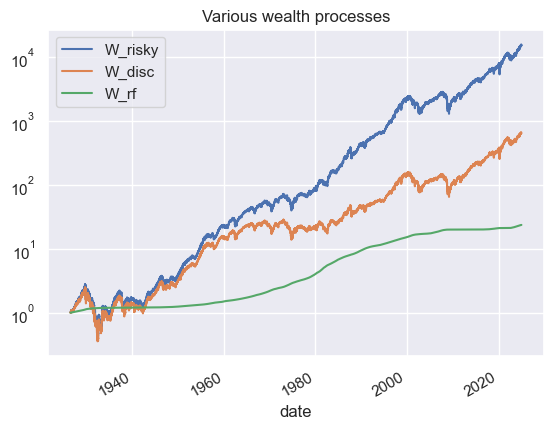

In [17]:
plot_wealth(df[['W_risky', 'W_disc', 'W_rf']], ttitle='Various wealth processes')

Let's compute the discounted return differently, via excess returns:

In [18]:
rtrn_excess = df['vwretd'] - df['rf']
df['W_excess'] = (rtrn_excess.fillna(0) + 1).cumprod()
df['W_excess'] = df['W_excess'] 

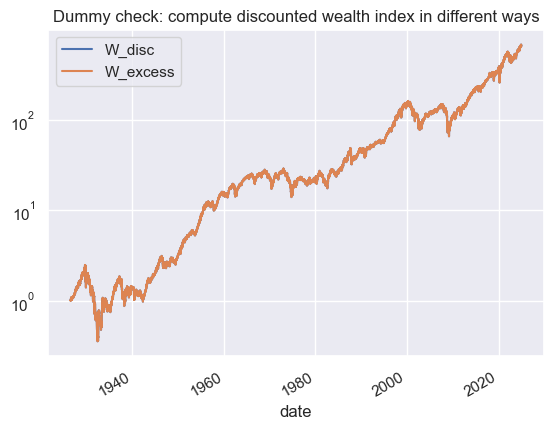

In [19]:
plot_wealth(df[['W_disc', 'W_excess']], ttitle='Dummy check: compute discounted wealth index in different ways')

In [20]:
df[['W_disc', 'W_excess']].tail(3)

,W_disc,W_excess
date,,
2024-12-27,658.010235,658.175169
2024-12-30,650.804931,650.966834
2024-12-31,647.945130,648.105835


In [21]:
if 'W_excess' in df.columns:
    del df['W_excess']

Let's compute integrated variance (via quadratic variation) differently:

In [22]:
df['QV_raw'] = (df['vwretd']**2).cumsum()

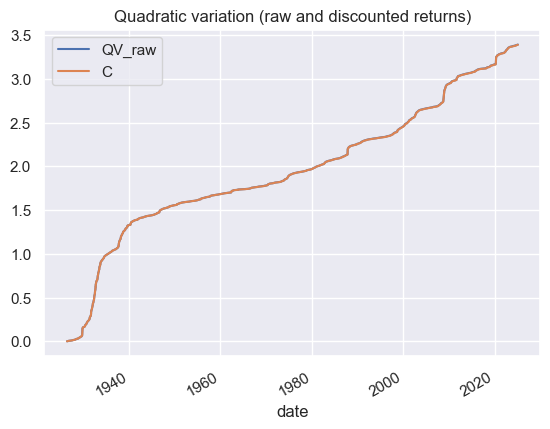

In [23]:
df[['QV_raw', 'C']].plot(title='Quadratic variation (raw and discounted returns)');

In [24]:
df[['QV_raw', 'C']].tail(3)

,QV_raw,C
date,,
2024-12-27,3.391355,3.388842
2024-12-30,3.391471,3.388962
2024-12-31,3.391489,3.388981


In [25]:
if 'QV_raw' in df.columns:
    del df['QV_raw']

## Creating the panel for the paper

In [26]:
df.iloc[7368:7372]

,vwretd,totcnt,rf,W_risky,W_rf,W_disc,disc_ret,C,R
date,,,,,,,,,
1951-06-28,-0.012272,90,0.00006,5.637718,1.270663,4.436832,-0.012331,1.583648,2.279961
1951-06-29,-0.007006,90,0.00006,5.598220,1.270739,4.405484,-0.007066,1.583698,2.272896
1951-07-02,0.006897,90,0.00006,5.636831,1.270815,4.435602,0.006837,1.583744,2.279732
1951-07-03,0.006537,90,0.00006,5.673679,1.270892,4.464330,0.006477,1.583786,2.286209


In [27]:
idx_July1951 = 7370

In [28]:
df.index[idx_July1951]

Timestamp('1951-07-02 00:00:00')

Plot saved as plots/US.png


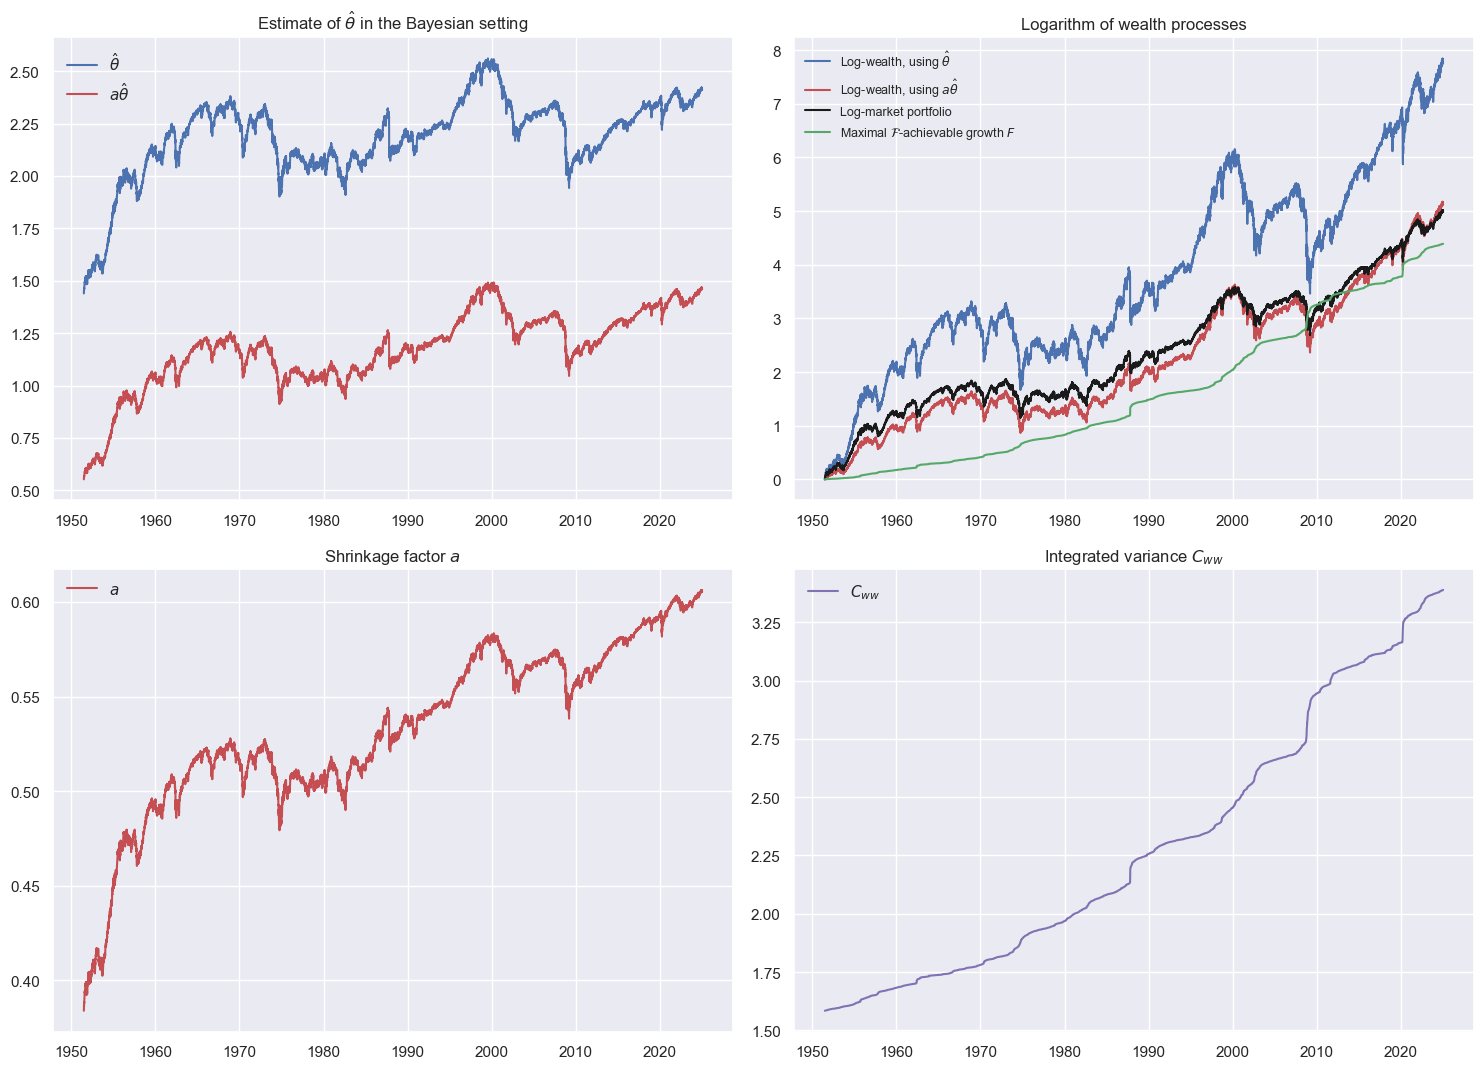

In [29]:
plot_panel(df, start_of_plot=idx_July1951, filename='US')

## Some robustness checks

Let's use data only after 1957, March 1, when the index contains around 500 stocks.

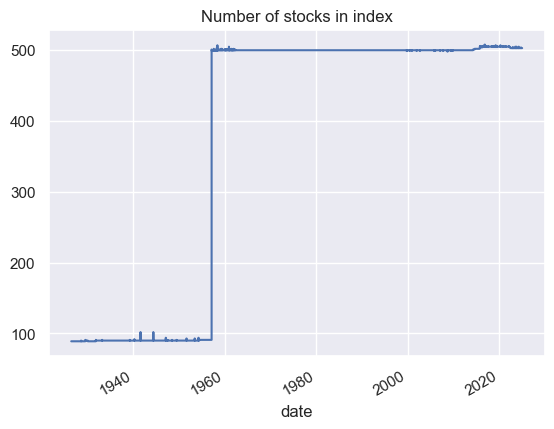

In [30]:
df['totcnt'].plot(title='Number of stocks in index');

In [31]:
idx_500 = 8825 
df.iloc[idx_500-1:].head(4)

,vwretd,totcnt,rf,W_risky,W_rf,W_disc,disc_ret,C,R
date,,,,,,,,,
1957-02-28,-0.003458,91,0.00013,15.358730,1.397752,10.988166,-0.003588,1.649422,3.219813
1957-03-01,0.009440,501,0.00011,15.503717,1.397906,11.090675,0.009329,1.649509,3.229142
1957-03-04,0.006674,499,0.00011,15.607188,1.398059,11.163466,0.006563,1.649552,3.235706
1957-03-05,0.004372,499,0.00011,15.675423,1.398213,11.211039,0.004262,1.649570,3.239967


If only data are used after 500 stocks are included, again starting the plot 7370 trading days later.

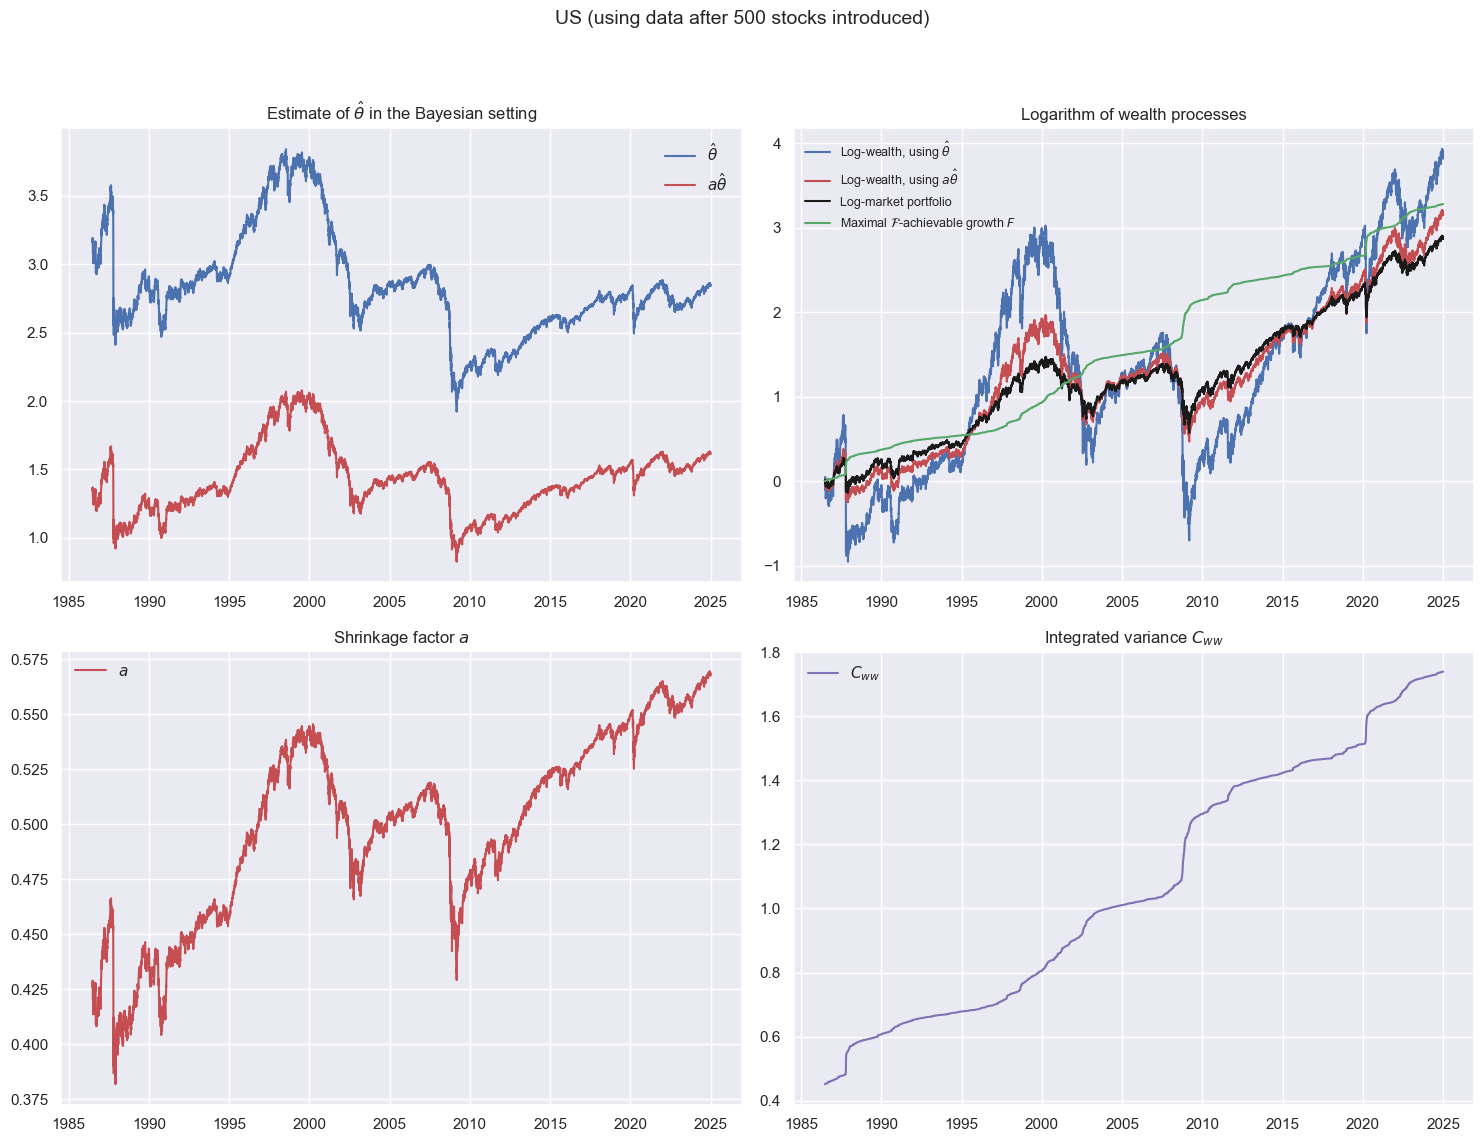

In [32]:
plot_panel(df, start_of_plot=idx_500+7370, start_of_data=idx_500, ttitle='US (using data after 500 stocks introduced)')

Now restrict $\nu$ to lie in a certain range $(a,b)$, via a restricted Gaussian prior.

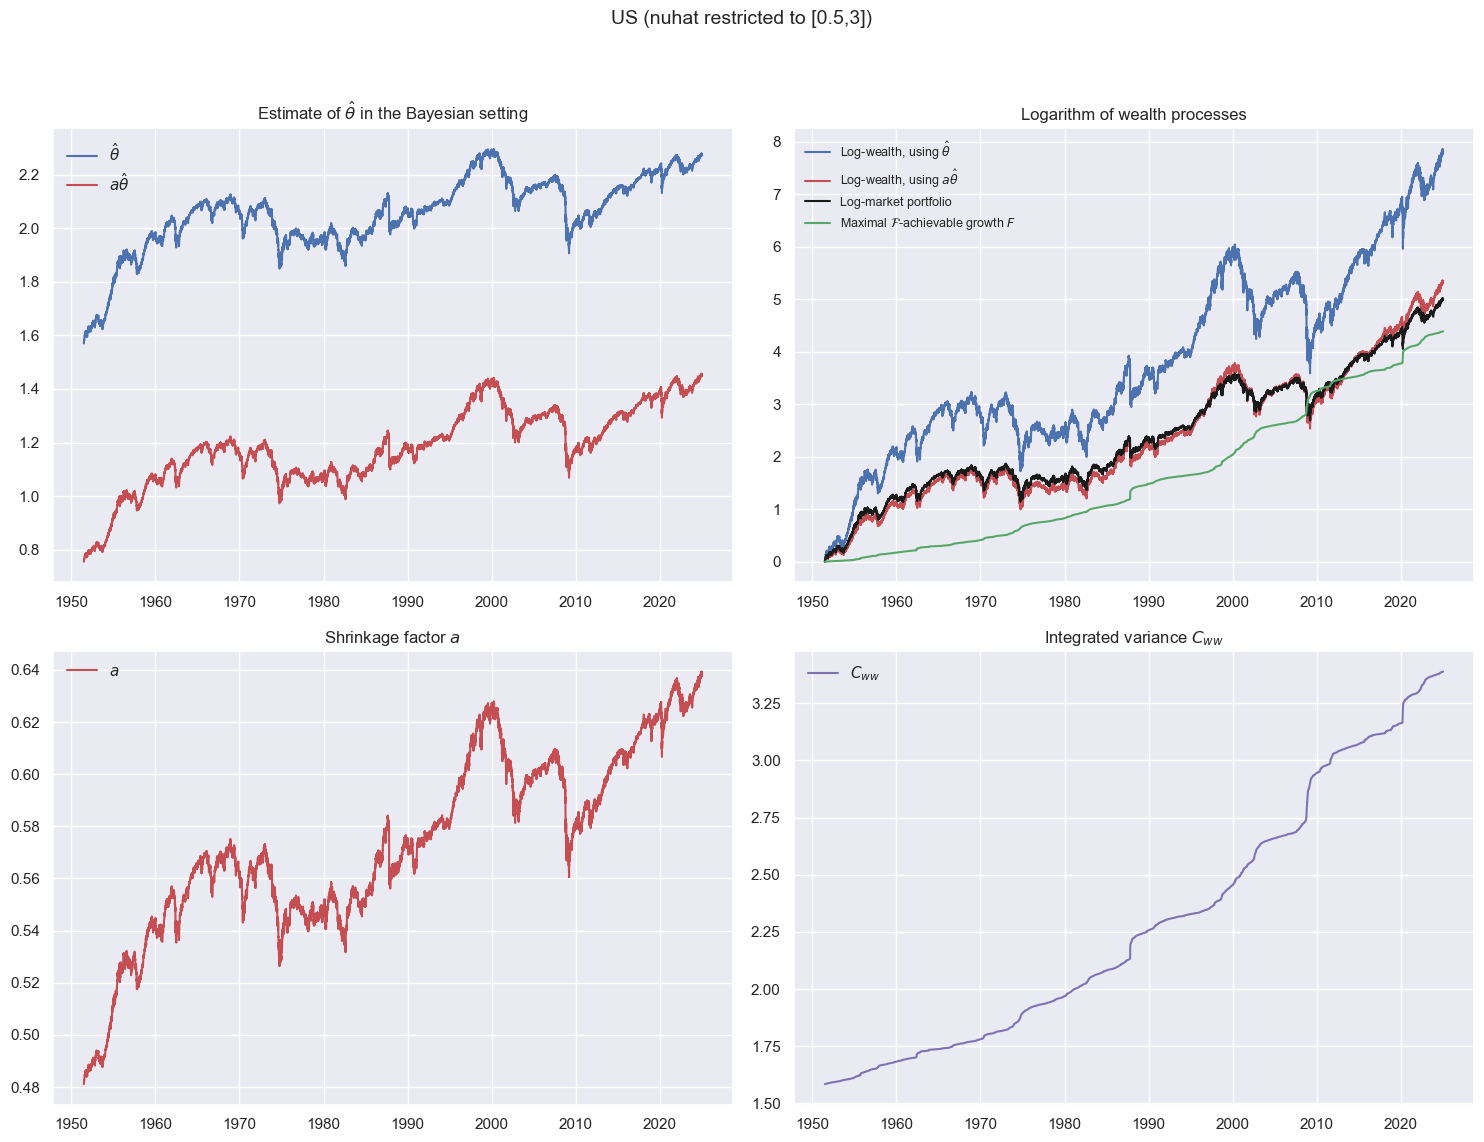

In [33]:
bounds = [0.5, 3]
plot_panel(df, start_of_plot=idx_July1951, restricted=bounds, ttitle=f'US (nuhat restricted to [{bounds[0]},{bounds[1]}])')

### Dummy check: Maximal achievable $\mathcal F$ growth

In [34]:
start = idx_500

In [35]:
dC = df['C'].diff()
F = (dC * ((df['R'] / df['C']).shift(1))**2).cumsum() / 2
F = F.iloc[start:] - F.iloc[start]

Alternative computation via half of quadratic variation of log wealth:

In [36]:
nuhat = df['R'] / df['C']
W_nuhat = (df['disc_ret'] * nuhat.shift(1) + 1).fillna(1).cumprod()

tmp = np.log(W_nuhat.iloc[start:] /  W_nuhat.iloc[start])
QV_log_wealth = (tmp.diff()**2).cumsum()/2
QV_log_wealth.iloc[0] = 0.0

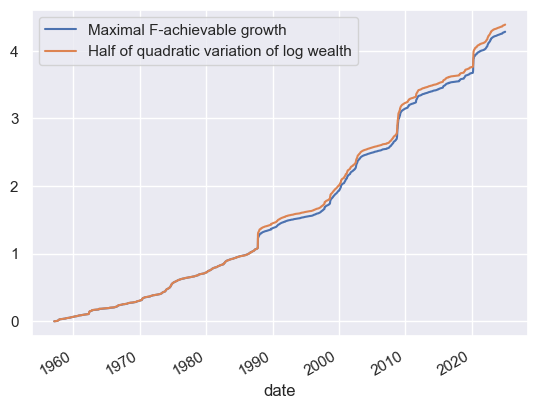

In [37]:
F.plot()
QV_log_wealth.plot()
plt.legend(['Maximal F-achievable growth', 'Half of quadratic variation of log wealth']);

Difference appears on Black Monday (19 Oct 1987), when the market exhibits a huge negative return that makes the normal approximation invalid.

In [38]:
df[idx_500+7700:].head()

,vwretd,totcnt,rf,W_risky,W_rf,W_disc,disc_ret,C,R
date,,,,,,,,,
1987-10-15,-0.025173,500,0.00027,347.099570,8.126985,42.709515,-0.025436,2.134810,4.819920
1987-10-16,-0.051526,500,0.00027,329.214917,8.129179,40.497930,-0.051782,2.137491,4.768138
1987-10-19,-0.194583,500,0.00027,265.155291,8.131374,32.608917,-0.194800,2.175438,4.573337
1987-10-20,0.042938,500,0.00027,276.540529,8.133569,33.999899,0.042656,2.177258,4.615994
1987-10-21,0.088117,500,0.00027,300.908451,8.135765,36.985882,0.087823,2.184971,4.703817
